# Given haloID or subhaloID get
1. halo gas (ICM) or subhalo gas (IGM / ISM)
2. thermodynamic profiles (density, temperature, pressure, entropy, metallicity)
3. xray theoretical (emissivity, intensity)
4. xray observational
5. spectrum

In [8]:
from soxs.utils import soxs_cfg
soxs_cfg.set("soxs", "bkgnd_nH", "0.018") # avoid configparser error by specifying here
import soxs

In [9]:
import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il
import pylab as plt

import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits

## Pick a galaxy, load the data, and prepare it for yt

In [10]:
basePath = "../../../sims.TNG/TNG50-1/output/"
snap = 91
z = 0.1
emin = 0.5
emax = 2.0

## Given haloID / subhaloID getting halo gas (ICM)

In [11]:
#if haloID is given => want halo gas (ICM)

haloID = 50 # with central subhalo ID 377004 print(halo["GroupFirstSub"])
halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)
fields = ["Coordinates", "GFM_CoolingRate", "Density", "InternalEnergy", "ElectronAbundance", "StarFormationRate", "Masses", "GFM_Metallicity", "Velocities"]
gas = il.snapshot.loadHalo(basePath, snap, haloID, 'gas', fields=fields)

## Given haloID / subhaloID getting subhalo gas (IGM / ISM)

In [12]:
header = il.groupcat.loadHeader(basePath, snap)
with h5py.File(il.snapshot.snapPath(basePath, snap),'r') as f:
    header_snap = dict(f['Header'].attrs)

In [13]:
filename = "halo_%d.hdf5" % haloID #% subID
with h5py.File(filename,'w') as f:
    for key in gas.keys():
        f['PartType0/' + key] = gas[key]
        
    # some metadata that yt demands
    f.create_group('Header')
    f['Header'].attrs['NumFilesPerSnapshot'] = 1
    f['Header'].attrs['MassTable'] = header_snap['MassTable']
    f['Header'].attrs['BoxSize'] = header['BoxSize']
    f['Header'].attrs['Time'] = header['Time']
    f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
    
    # Must have the next six for correct units
    f["Header"].attrs["HubbleParam"] = header["HubbleParam"]
    f["Header"].attrs["Omega0"] = header["Omega0"]
    f["Header"].attrs["OmegaLambda"] = header["OmegaLambda"]

    # These correspond to the values from the TNG simulations
    f["Header"].attrs["UnitLength_in_cm"] = header_snap['UnitLength_in_cm']
    f["Header"].attrs["UnitMass_in_g"] = header_snap['UnitMass_in_g']
    f["Header"].attrs["UnitVelocity_in_cm_per_s"] = header_snap['UnitVelocity_in_cm_per_s']

## Load the data into yt

In [14]:
ds = yt.load(filename)

yt : [INFO     ] 2025-06-21 08:57:05,089 Redshift is not set in Header. Assuming z=0.
yt : [INFO     ] 2025-06-21 08:57:05,113 Calculating time from 9.096e-01 to be 4.356e+17 seconds
yt : [INFO     ] 2025-06-21 08:57:05,230 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-06-21 08:57:05,231 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-06-21 08:57:05,233 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-06-21 08:57:05,235 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-06-21 08:57:05,237 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-06-21 08:57:05,239 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2025-06-21 08:57:05,239 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-06-21 08:57:05,240 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-06-21 08:57:05,241 Parameters: omega_radiation           =

In [15]:
def hot_gas(pfilter, data):
    pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5
    pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
    pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
    return (pfilter1 & pfilter2) & pfilter3

yt.add_particle_filter("hot_gas", function=hot_gas,
                       filtered_type='gas', requires=["temperature","density"])

In [16]:
ds.add_particle_filter("hot_gas")

yt : [INFO     ] 2025-06-21 08:57:05,293 Allocating for 3.302e+06 particles
Initializing refined index: 100%|██████████| 13/13 [00:11<00:00,  1.17it/s]


True

## Quickly visualize the gas in the halo

In [17]:
c = ds.arr([halo["GroupPos"][0], halo["GroupPos"][1], halo["GroupPos"][2]], "code_length")
#c = ds.arr([shalo["SubhaloPos"][0], shalo["SubhaloPos"][1], shalo["SubhaloPos"][2]], "code_length") #if subhaloID given

In [18]:
#del has, halo #,shalo

In [19]:
prj = yt.ProjectionPlot(ds, "z", ("gas","density"), width=(0.2, "Mpc"), center=c)
prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.set_cmap(("gas", "density"), "magma")
prj.show()

yt : [INFO     ] 2025-06-21 08:57:18,599 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:18,601 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:18,609 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:18,611 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:18,619 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


yt : [INFO     ] 2025-06-21 08:57:26,637 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:26,638 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:26,646 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:26,647 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:26,649 Making a fixed resolution buffer of (('hot_gas', 'density')) 800 by 800



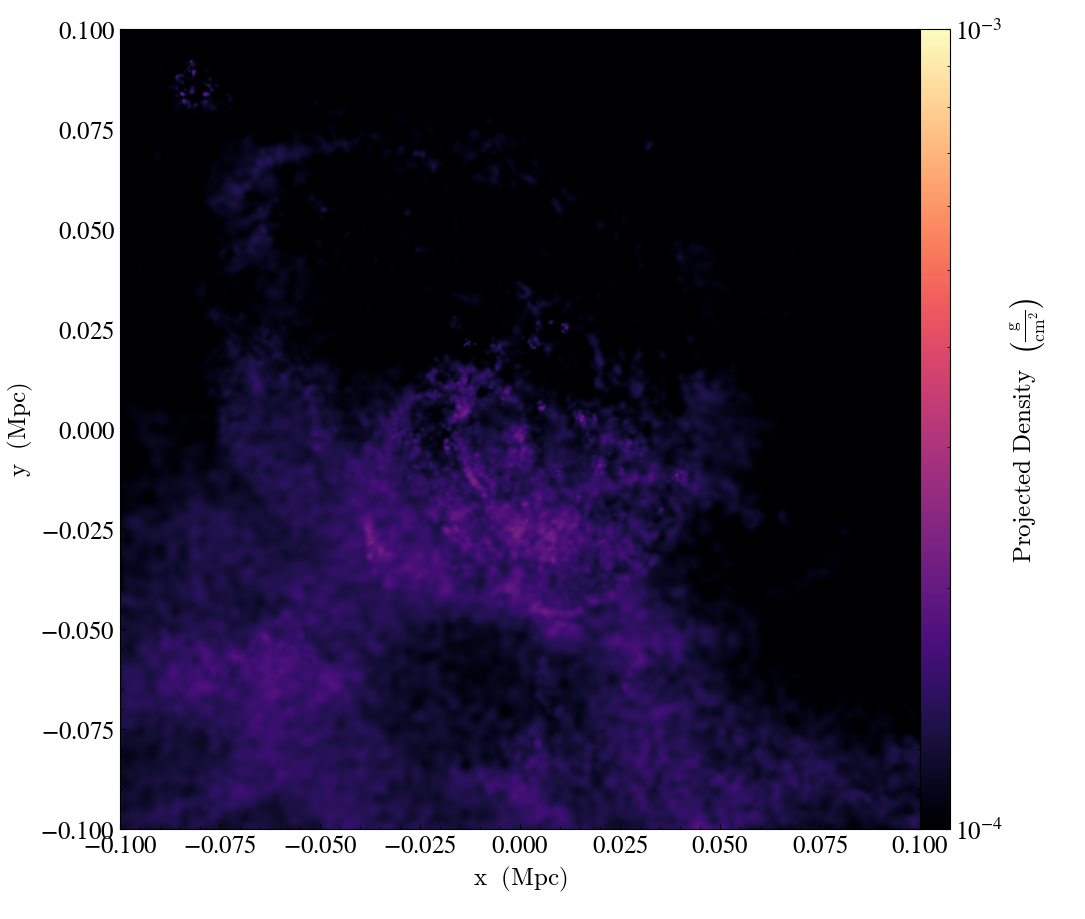

In [20]:
prj = yt.ProjectionPlot(ds, "z", ("hot_gas","density"), width=(0.2, "Mpc"), center=c)
prj.set_zlim(("hot_gas","density"), 1.0e-4, 1.0e-3)
#prj.set_zlim(("hot_gas","density"), 1.0e-4, 1.0)
prj.set_cmap(("hot_gas", "density"), "magma")
prj.show()

In [21]:
prj = yt.ProjectionPlot(ds, "z", ("gas","temperature"), width=(0.2, "Mpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
#prj.set_cmap(("gas", "temperature"), "magma")
prj.show()

yt : [INFO     ] 2025-06-21 08:57:36,297 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:36,299 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:36,302 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:36,303 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:36,304 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800
yt : [INFO     ] 2025-06-21 08:57:40,636 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


yt : [INFO     ] 2025-06-21 08:57:56,665 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:56,667 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:56,676 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:57:56,678 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:57:56,681 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800
yt : [INFO     ] 2025-06-21 08:58:07,197 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



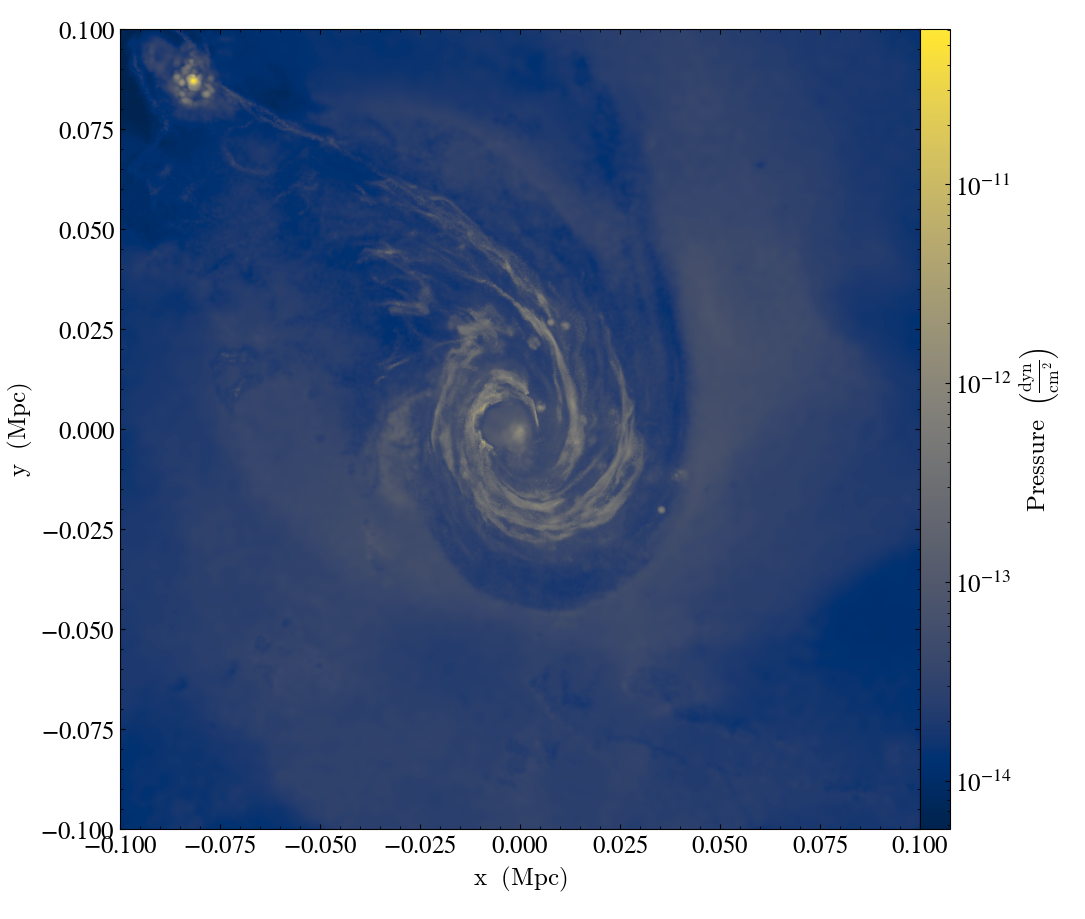

In [22]:
prj = yt.ProjectionPlot(ds, "z", ("gas","pressure"), width=(0.2, "Mpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.set_cmap(("gas", "pressure"), "cividis")
prj.show()

yt : [INFO     ] 2025-06-21 08:58:13,595 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:58:13,597 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:58:13,600 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:58:13,601 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:58:13,602 Making a fixed resolution buffer of (('gas', 'entropy')) 800 by 800
yt : [INFO     ] 2025-06-21 08:58:18,252 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



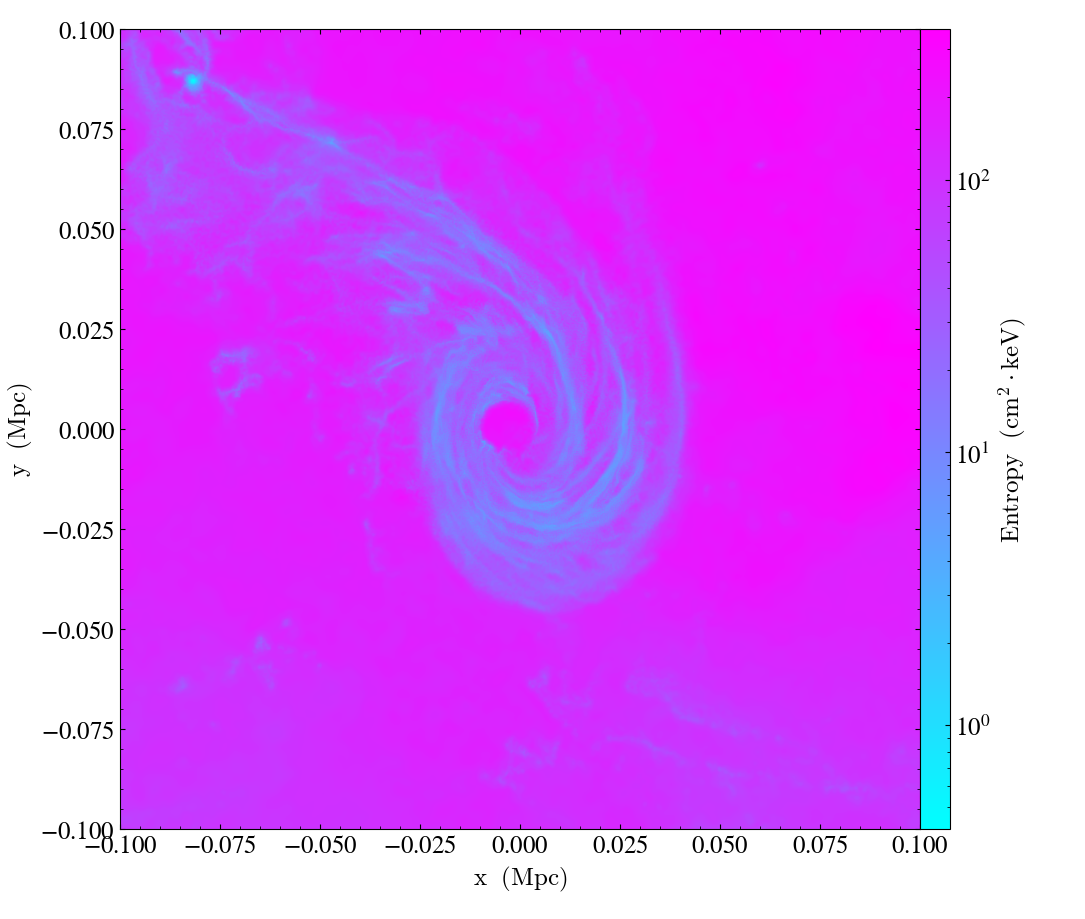

In [23]:
prj = yt.ProjectionPlot(ds, "z", ("gas","entropy"), width=(0.2, "Mpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.set_cmap(("gas", "entropy"), "cool")
prj.show()

In [24]:
prj = yt.ProjectionPlot(ds, "z", ("gas","metallicity"), width=(0.2, "Mpc"), center=c, weight_field=("gas", "density"))
#prj.set_zlim(("gas","density"), 1.0e-4, 1.0)
prj.set_cmap(("gas", "metallicity"), "autumn")
prj.show()

yt : [INFO     ] 2025-06-21 08:58:23,366 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:58:23,367 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:58:23,376 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:58:23,377 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:58:23,380 Making a fixed resolution buffer of (('gas', 'metallicity')) 800 by 800
yt : [INFO     ] 2025-06-21 08:58:27,881 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


## Configure the x-ray emission, and observation, models

In [25]:
nbins = 10000
source_model = pyxsim.CIESourceModel(
    "apec", emin, emax, nbins, ("hot_gas","metallicity"),
    temperature_field=("hot_gas","temperature"),
    emission_measure_field=("hot_gas", "emission_measure"),
)

pyxsim : [INFO     ] 2025-06-21 08:58:36,726 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-06-21 08:58:36,727 kT_max = 64 keV


## X-ray Emissivity and Intensity Plot

In [26]:
xray_fields = source_model.make_source_fields(ds, emin, emax)

pyxsim : [INFO     ] 2025-06-21 08:58:36,740 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-06-21 08:58:36,742 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

In [27]:
prj = yt.ProjectionPlot(ds, "z", xray_fields[0], width = (0.2, "Mpc"), center = c)
#prj.set_zlim(xray_fields[0], 1.0e3, 1.0e7)
prj.set_cmap(xray_fields[0], "magma")
prj.show()

yt : [INFO     ] 2025-06-21 08:59:20,437 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:59:20,439 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:59:20,442 xlim = 19674.582275 19810.062256
yt : [INFO     ] 2025-06-21 08:59:20,444 ylim = 3289.833496 3425.313477
yt : [INFO     ] 2025-06-21 08:59:20,446 Making a fixed resolution buffer of (('hot_gas', 'xray_emissivity_0.5_2.0_keV')) 800 by 800


In [28]:
frb = prj.frb[xray_fields[0]]
data_array = np.array(frb)
np.savetxt("xray_emissiviity.txt", data_array)

In [29]:
xray_fields2 = source_model.make_intensity_fields(ds, emin, emax, redshift=z)

pyxsim : [INFO     ] 2025-06-21 08:59:33,830 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-06-21 08:59:33,832 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

yt : [INFO     ] 2025-06-21 09:00:15,262 xlim = -67.739991 67.739991
yt : [INFO     ] 2025-06-21 09:00:15,265 ylim = -67.739991 67.739991
yt : [INFO     ] 2025-06-21 09:00:15,267 zlim = -30917.106915 30917.106915
yt : [INFO     ] 2025-06-21 09:00:15,271 Making a fixed resolution buffer of (('hot_gas', 'xray_intensity_0.5_2.0_keV')) 800 by 800



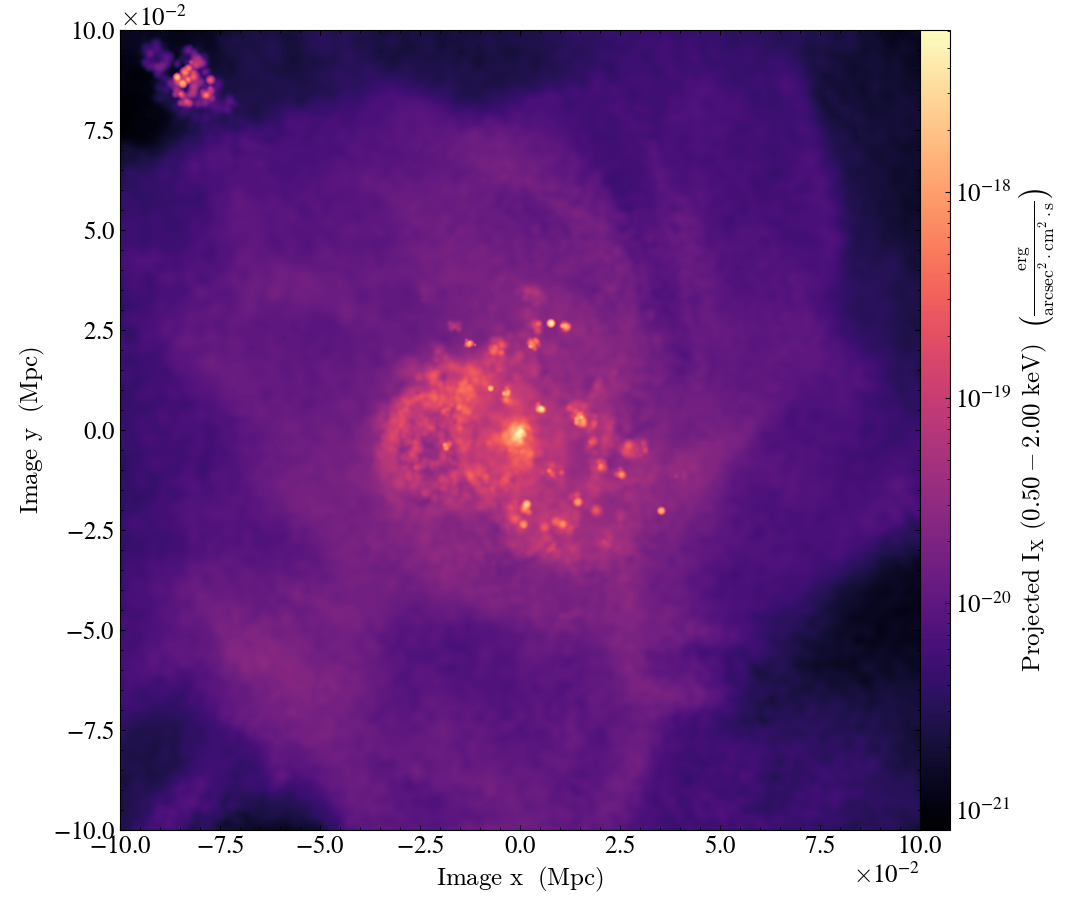

In [30]:
prj = yt.OffAxisProjectionPlot(
    ds, [0.0, 0.0, 1.0], xray_fields2[-2],  # Normal vector along z-axis
    width=(0.2, "Mpc"),
    center=c,
    north_vector=[0.0, 1.0, 0.0]  # Upward direction along y-axis
)
#prj.set_zlim(('gas', f'xray_intensity_{emin}_{emax}_keV'), zmin=1.0e-17, zmax=1.0e-14)
prj.set_cmap(('hot_gas', f'xray_intensity_{emin}_{emax}_keV'), "magma")
prj.show()

## Generate the mock x-ray emission

In [31]:
exp_time = (1e6, "s") # exposure time
area = (3000.0, "cm**2") # collecting area
redshift = z

In [32]:
width = ds.quan(1.0, "Mpc")
le = c - 0.5*width
re = c + 0.5*width
box = ds.box(le, re)

In [33]:
n_photons, n_cells = pyxsim.make_photons(f"halo_{haloID}_photons", box, redshift, area, exp_time, source_model)

pyxsim : [INFO     ] 2025-06-21 09:00:36,055 Cosmology: h = 0.6774, omega_matter = 0.3089, omega_lambda = 0.6911
pyxsim : [INFO     ] 2025-06-21 09:00:36,058 Using emission measure field '('hot_gas', 'emission_measure')'.
pyxsim : [INFO     ] 2025-06-21 09:00:36,059 Using temperature field '('hot_gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/2064502 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-06-21 09:08:29,507 Finished generating photons.
pyxsim : [INFO     ] 2025-06-21 09:08:29,509 Number of photons generated: 64322
pyxsim : [INFO     ] 2025-06-21 09:08:29,510 Number of cells with photons: 3061


In [34]:
n_events = pyxsim.project_photons(f"halo_{haloID}_photons", f"halo_{haloID}_events", "z", (45.,30.),
                                  absorb_model="wabs", nH=0.01)

pyxsim : [INFO     ] 2025-06-21 09:08:29,523 Foreground galactic absorption: using the wabs model and nH = 0.01.


Projecting photons from cells/particles :   0%|          | 0/3061 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2025-06-21 09:08:30,524 Detected 61166 events.


In [35]:
events = pyxsim.EventList(f"halo_{haloID}_events.h5")
events.write_to_simput(f"halo_{haloID}", overwrite=True)

soxs : [WARNING  ] 2025-06-21 09:08:30,589 Overwriting halo_50_phlist.fits.
soxs : [INFO     ] 2025-06-21 09:08:30,677 Writing source 'halo_50' to halo_50_phlist.fits.


## Create a synthetic observation of these x-rays with instruments

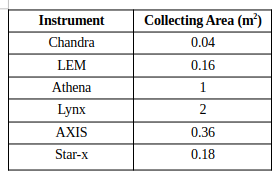

In [36]:
instrument = "lem_outer_array" #"lynx_lxm", "axis", "star-x", "lem_outer_array", "chandra_acisi_cy0", "athena_wfi"
soxs.instrument_simulator(f"halo_{haloID}_simput.fits", f"halo_{haloID}_evt.fits", (1e5, "s"), instrument, (45.,30.), overwrite=True, foreground=False, ptsrc_bkgnd=False)

soxs : [INFO     ] 2025-06-21 09:08:30,703 Making observation of source in halo_50_evt.fits.
soxs : [INFO     ] 2025-06-21 09:08:31,808 Detecting events from source halo_50.
soxs : [INFO     ] 2025-06-21 09:08:31,810 Applying energy-dependent effective area from lem_300522.arf.
soxs : [INFO     ] 2025-06-21 09:08:31,814 Pixeling events.
soxs : [INFO     ] 2025-06-21 09:08:31,816 Scattering events with a gaussian-based PSF.
soxs : [INFO     ] 2025-06-21 09:08:31,819 4540 events were detected from the source.
soxs : [INFO     ] 2025-06-21 09:08:31,820 Scattering energies with RMF lem_2.5ev_110422.rmf.


Scattering energies :   0%|          | 0/4540 [00:00<?, ?it/s]

soxs : [INFO     ] 2025-06-21 09:08:32,504 Adding background events.
soxs : [INFO     ] 2025-06-21 09:08:33,361 Adding in instrumental background.
soxs : [INFO     ] 2025-06-21 09:08:33,516 Making 341052 events from the instrumental background.
soxs : [INFO     ] 2025-06-21 09:08:33,977 Writing events to file halo_50_evt.fits.
soxs : [INFO     ] 2025-06-21 09:08:34,375 Observation complete.


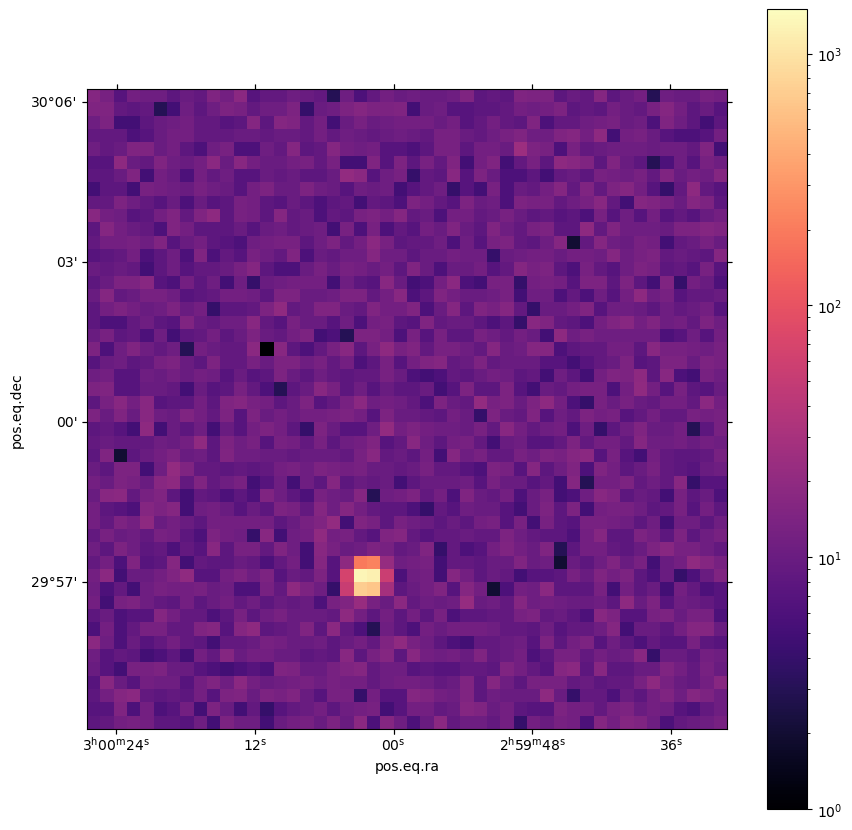

In [37]:
soxs.write_image(f"halo_{haloID}_evt.fits", f"halo_{haloID}_img.fits", emin=emin, emax=emax, reblock=1, overwrite=True)
center_sky = SkyCoord(45, 30, unit='deg', frame='fk5')
region_sky = RectangleSkyRegion(center=center_sky, width=30 * u.arcmin, height=30*u.arcmin)
with fits.open(f"halo_{haloID}_img.fits") as f:
    w = wcs.WCS(header=f[0].header)
    fig, ax = soxs.plot_image(f"halo_{haloID}_img.fits", stretch='log', cmap='magma', vmax=1500.0, width=0.2)
ax.add_artist(region_sky.to_pixel(w).as_artist())
fig.savefig(f"halo_{haloID}_plot.png", dpi=300)

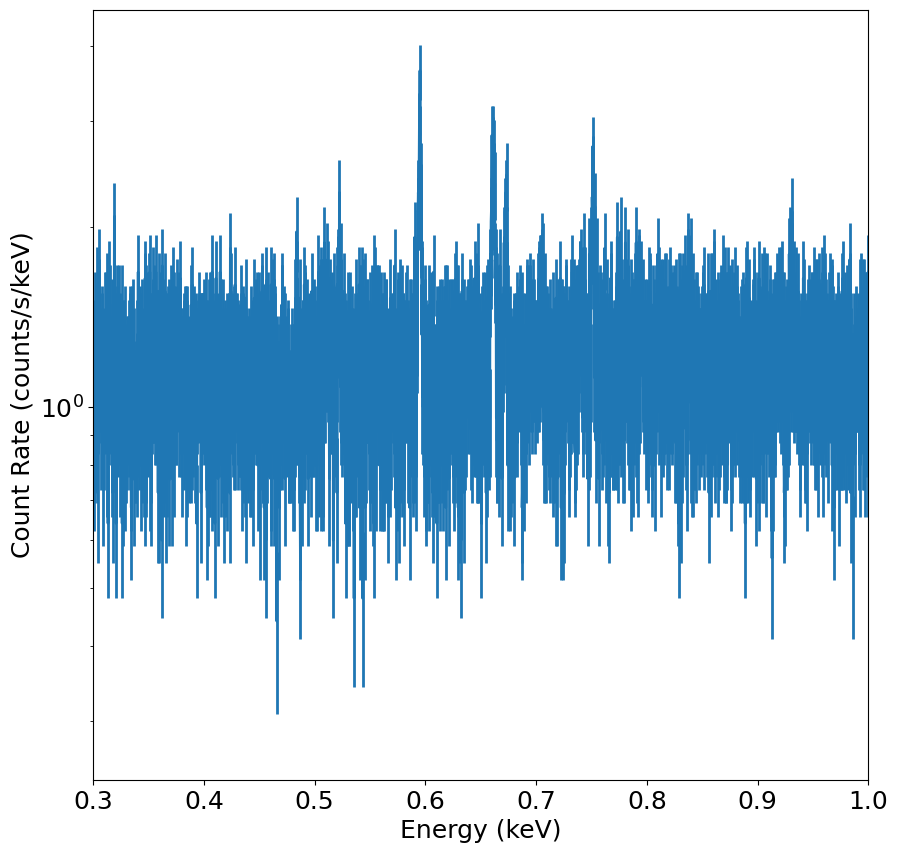

In [38]:
soxs.write_spectrum(f"halo_{haloID}_evt.fits", f"halo_{haloID}_evt.pi", overwrite=True)
fig, ax = soxs.plot_spectrum(f"halo_{haloID}_evt.pi", xmin=0.3, xmax=1.0, xscale="linear")